# **Even Odd Classification using Combinatorial Optimisation**
The problem statement is to divide an array of integers in two subsets. One subset will have only Even numbers and the other will have only odd numbers. Though the problem is very easily solvable using conventional classical computers, but here a different formulation is introduced which is suitable for Ising devices like fixtars Amplify, D'wave or other providers like Hitachi or Fujitsu etc.

In [111]:
# #####################   Necessary Installations  ######################

# !pip install amplify
# !pip install amplify[extra]

In [112]:
#####################   Necessary Imports   ##########################

import numpy as np
import pandas as pd
import networkx as nx
from amplify import BinaryPoly, BinaryMatrix, BinaryQuadraticModel, gen_symbols, Solver
from amplify.client import FixstarsClient
from amplify.client.ocean import DWaveSamplerClient, LeapHybridSamplerClient

Here we are generating array of random integers within a range. One can put array of flexible length. For demnonstration purpose a small array (with repetative or non-repetative elements) is chosen. In this approach if we want to classify K numbers, then we will need K number of Logical Variables. Every number is associated with a binary variable, which can take value either 1 or 0.

In [113]:
n = 10 # number of inputs

N = np.random.randint(1,100,n)
print('Input numbers are:\n',N)

Input numbers are:
 [35 13 28 61 89 78 49 30  3 56]


### **QUBO matrix generation for the problem**
Here we are importing **BinaryMatrix** method from amplify. Where i,j th element of the Binary matrix (or QUBO) will be,
$$m_{ij}=(-1)^{(1+N_{i}+N_{j})}$$


In [114]:
##############  Defining QUBO function for QUBO generation from arbitrary array of integers  ##############

def QUBO(N):
    k = N.shape[0]
    m = BinaryMatrix(k)
    for i in range(k):
        for j in range(i,k):
            m[i,j] = (-1)**(1 + N[i] + N[j])
    return m



def Even_Odd_result(solution, numbers):  # Filters the even odd numbers from bitstring
    S1, S2 = [], []
    subsets = [S1, S2]

    for i in range(len(solution)):
        if solution[i] == 0:
            S1.append(numbers[i])
        elif solution[i] == 1:
            S2.append(numbers[i])
    
    Label_Assignment(subsets)
    print("\nEven and Odd numbers are separated")



def Label_Assignment(subsets):
    P = None
    for i in range(len(subsets)):
        if len(subsets[i]) != 0:
            P = i

    if subsets[P][0] %2 == 0:
        even = subsets[P]
        odd = subsets[1-P]
    else:
        odd = subsets[P]
        even = subsets[1-P]
    print(' Even numbers:',even)
    print('  Odd numbers:',odd)




def Best_solution(result):
    sols = []
    for i in range(len(result)):
        y = result[i]
        x = list(y.values.values())
        e = y.energy
        f = y.frequency
        z = {'x':x,'energy':e,'frequency':f}
        sols.append(z)
    df = pd.DataFrame(sols)
    i = int(df[['frequency']].idxmax())
    X = sols[i]['x']
    return X

In [115]:

qubo = QUBO(N)
print("       Our QUBO for the problem is:\n\n",qubo.to_numpy())  # Prints QUBO matrix in Numpy array format

       Our QUBO for the problem is:

 [[-1. -1.  1. -1. -1.  1. -1.  1. -1.  1.]
 [ 0. -1.  1. -1. -1.  1. -1.  1. -1.  1.]
 [ 0.  0. -1.  1.  1. -1.  1. -1.  1. -1.]
 [ 0.  0.  0. -1. -1.  1. -1.  1. -1.  1.]
 [ 0.  0.  0.  0. -1.  1. -1.  1. -1.  1.]
 [ 0.  0.  0.  0.  0. -1.  1. -1.  1. -1.]
 [ 0.  0.  0.  0.  0.  0. -1.  1. -1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]]


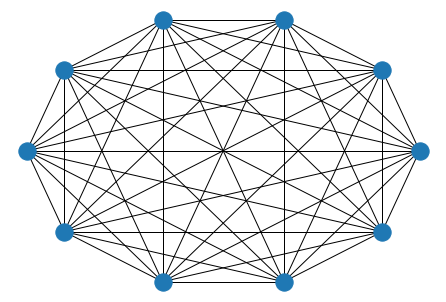

In [116]:
#############  Grawing Graph of the problem from QUBO   ################

G = nx.from_numpy_matrix(qubo.to_numpy())
nx.draw_shell(G,label=True,)

### **Creating client Object**
Here we are setting up our Fixstars amplify solver with some intrinsic parameters.

In [117]:
client = FixstarsClient()
client.token = "mBle_KURyYutT.NDbsTpovEeCWf-vScH"
client.parameters.timeout = 1000
# client.parameters.outputs.duplicate = True  
client.parameters.outputs.num_outputs = 0  

### **Solving QUBO with Amplify**
The result will be a binary array of 0's and 1's. We can filter the input array of integers with respect to the binary array. Elements with value 1 will be in one subset and 0's will be in another subset. Finally we get 2 subsets, out of which one with all evens and other with all odd numbers.\
**But certainly we do not know which one is even subset and which one is odd**

In [118]:
################## Solution #########################
model = BinaryQuadraticModel(qubo)


solver = Solver(client)
result = solver.solve(model)
for solution in result:
    print(f"values = {list(solution.values.values())} energy = {solution.energy} frequency = {solution.frequency}")

best_solution = Best_solution(result)
print('\n\nInput numbers:',N)
Even_Odd_result(best_solution,N)

values = [1, 1, 0, 1, 1, 0, 1, 0, 1, 0] energy = -21.0 frequency = 1


Input numbers: [35 13 28 61 89 78 49 30  3 56]
 Even numbers: [28, 78, 30, 56]
  Odd numbers: [35, 13, 61, 89, 49, 3]

Even and Odd numbers are separated


In [119]:
############# Solving with Dwave client  ##################



client = DWaveSamplerClient()
client.token = "DEV-d1f6e1d1c38fbe9219ce7713e110736473b657a0"
client.solver = "Advantage_system1.1"
client.parameters.num_reads = 1000 


############   Solution   ######################
solver = Solver(client)
result = solver.solve(model)
for solution in result1:
    print(f"nvalues = {list(solution.values.values())} energy = {solution.energy} frequency = {solution.frequency}")

best_solution = Best_solution(result)
print('\n\nInput numbers:',N)
Even_Odd_result(best_solution,N)

nvalues = [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1] energy = -55.0 frequency = 583
nvalues = [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0] energy = -55.0 frequency = 417


Input numbers: [35 13 28 61 89 78 49 30  3 56]
 Even numbers: [28, 78, 30, 56]
  Odd numbers: [35, 13, 61, 89, 49, 3]

Even and Odd numbers are separated


In [120]:
############# Solving with Dwave hybrid client  ##################



client = LeapHybridSamplerClient()
client.token = "DEV-d1f6e1d1c38fbe9219ce7713e110736473b657a0"
client.solver = "hybrid_binary_quadratic_model_version2"
# client.parameters.time_limit = 3

############   Solution   ######################
solver = Solver(client)
result = solver.solve(model)
for solution in result:
    print(f"nvalues = {list(solution.values.values())} energy = {solution.energy} frequency = {solution.frequency}")


best_solution = Best_solution(result)
print('\n\nInput numbers:',N)
Even_Odd_result(best_solution,N)

nvalues = [1, 1, 0, 1, 1, 0, 1, 0, 1, 0] energy = -21.0 frequency = 1


Input numbers: [35 13 28 61 89 78 49 30  3 56]
 Even numbers: [28, 78, 30, 56]
  Odd numbers: [35, 13, 61, 89, 49, 3]

Even and Odd numbers are separated
